# GLM all file ploter

## Import

In [33]:
import os 
import numpy as np
from Helper_functions import *
# Connectivity imports
import pandas as pd
import ast
# Plotting
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# data file names
cam_files_name = 'cam0_'
working_dir = '/home/ag-schmitz-nwfz/yota/project'#'\\\\wsl.localhost\\Ubuntu\\home\\ag-schmitz-nwfz\\yota\\project'

# Session information
sampling_rate = 30000 # Hz
camara_sampling_rate = 200 # Hz
time_bin_width = 0.005 # s
diff_TTL_usual_value = 150 # ?
n_cam_switch = 9 # number of camara switches for each session
n_ROIs = 6
ROI_names = ["Wheel", "Vibrissae", "Nose", "Pupil", "Mouth", "Paw"]

# GLM Parameters
GLM_type = "binary_binary"
coef_save_path =  \
    os.path.join(working_dir, 'GLM', 'output_files', 'GLM_coef.npy')
all_GLM_coef = np.load(coef_save_path, allow_pickle=True).item()

# Get valid periods, thresholds and significance
all_awake_periods = np.load(os.path.join(working_dir,'GLM', 'output_files', 'valid_periods.npy'), 
                            allow_pickle=True).item()

sig_path =  \
    os.path.join(working_dir, 'GLM', 'output_files', 'GLM_sig.npy')
sig_GLM_coef = np.load(sig_path, allow_pickle=True).item() 

# Connectivity
connectivity = pd.read_csv(os.path.join(working_dir,'synaptic_connection', 'results_connectivity',
                                        'cluster_pair_info_with_connectivity_info_all_exp.csv'))
connectivity['spike_bundle_indx_pair'] = connectivity['spike_bundle_indx_pair'].apply(ast.literal_eval)
ROI_con = ROI_names.index('Vibrissae')

# Get data
path_2_spike_bundle =  \
    os.path.join(working_dir, 'data-single-unit')

# 17 files, 13 files no error, 11 files good data
# "2023-03-15"
good_sessions = ["2021-11-19", "2022-12-20", "2022-12-21", "2023-02-23", "2021-03-16",
                 "2023-03-21", "2023-03-22", "2023-04-14", "2023-04-17", "2023-08-11"]


experiments = [exp for exp in os.listdir(path_2_spike_bundle)
               if exp[:10] in good_sessions and not exp == '2023-03-15_15-23-14']
experiments.sort()

## File loop

In [ ]:
# GLM All file array
i = 0
all_unit_colors = np.array([])
unconnected_pair = []
connected_pair = []
connected_color = []

# file loop
for exp in experiments:
    if True: #exp == '2023-03-21_16-17-18'
        try:
            ## IMPORT SPIKE DATA
            Spke_Bundle, spiketimes, camera_change_times, SIN_data = \
                import_spike_data(exp, working_dir, path_2_spike_bundle)
            
            ## IMPORT BEHAVIOR DATA
            Behavior = import_behavior(exp, working_dir)
            
            ## GLM PIPELINE
            awake_periods = all_awake_periods[exp[:10]]
            
            # Get valid units and unit type
            valid_cluster_indx, cluster_type, unit_colors = \
                get_valid_cluster(Spke_Bundle, SIN_data)            

            # Save to array
            if i == 0:
                all_GLM_coef_array = all_GLM_coef[exp[:10]]
                sig_GLM_coef_array = sig_GLM_coef[exp[:10]]
                i = 1
            else:
                all_GLM_coef_array = np.append(all_GLM_coef_array, 
                                               all_GLM_coef[exp[:10]], axis=0)
                sig_GLM_coef_array = np.append(sig_GLM_coef_array,
                                               sig_GLM_coef[exp[:10]], axis=0)
            
            all_unit_colors = np.append(all_unit_colors, unit_colors, axis=0)
            
            # Connectivity analisis
            connectivity_exp = connectivity[connectivity['exp_name'] == exp]
            valid_cluster_indx = np.array(valid_cluster_indx)

            for p, pair in enumerate(connectivity_exp['spike_bundle_indx_pair']):

                # Get valid pairs' coefs
                if pair[0] in valid_cluster_indx and pair[1] in valid_cluster_indx:
                    pair_indx = [np.argwhere(valid_cluster_indx == pair[j])[0] for j in [0,1]]
                    coef_pair = [all_GLM_coef[exp[:10]][pair_indx[j], ROI_con] for j in [0,1]]
                    ps_color = unit_colors[pair_indx[0][0]]
                    
                    if connectivity_exp['connection'].iloc[p]:
                        connected_pair.append(coef_pair)
                        connected_color.append(ps_color)
                    else:
                        unconnected_pair.append(coef_pair)
        
        except:
            print("\n Error when processing file " + exp[:10])

102 102
462 462
303 303
314 314
231 231
330 330
621 621
518 518
413 413


## Histogram

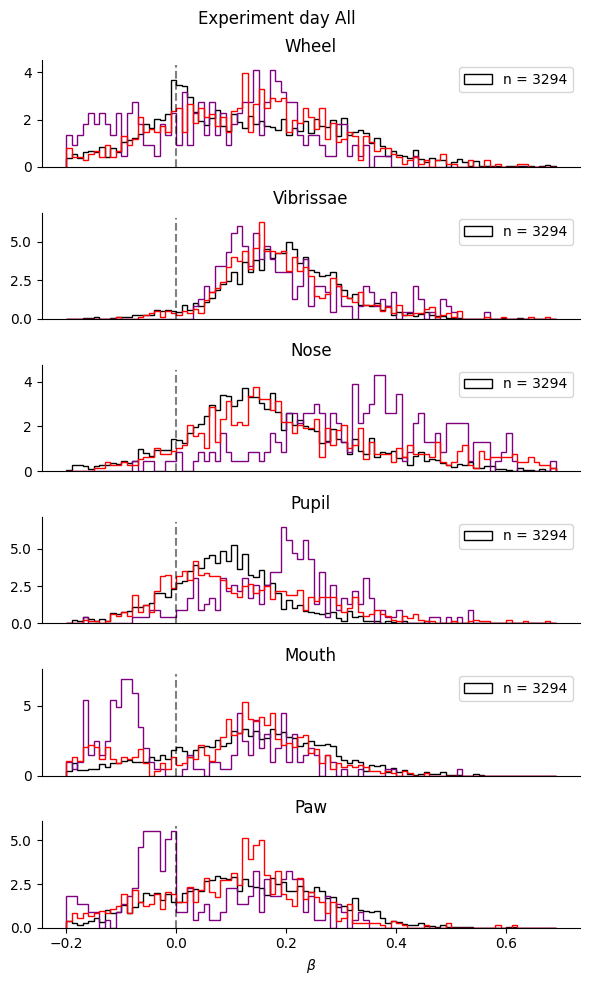

In [35]:
costume_bins = np.arange(-0.2, 0.7, 0.01)
plot_histogram_of_GLM(all_GLM_coef_array, ROI_names, all_unit_colors,
                      bins = costume_bins, exp = "All       ")

## Significance

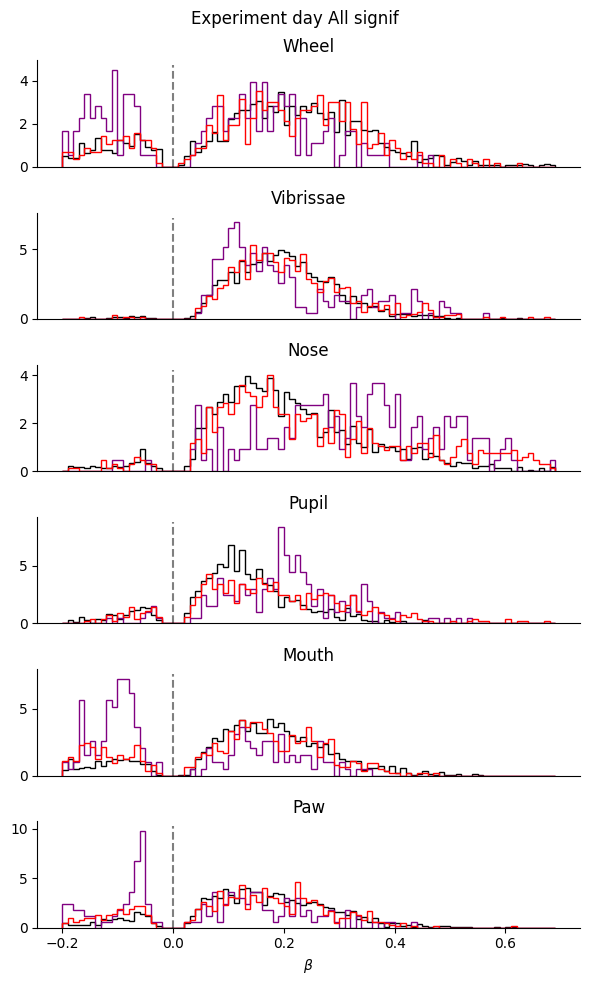

In [4]:
masked_array = np.where(sig_GLM_coef_array == 0, np.nan, all_GLM_coef_array)
plot_histogram_of_GLM(masked_array, ROI_names, all_unit_colors,
                      bins = costume_bins, exp = "All significant")

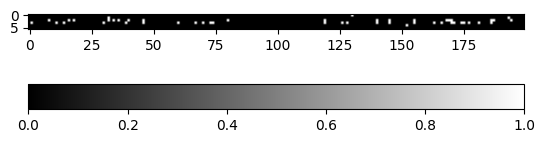

In [93]:
plt.imshow(sig_GLM_coef_array[:200,:].T, cmap="gray")
plt.colorbar(orientation="horizontal")
plt.show()

## 2d scatter

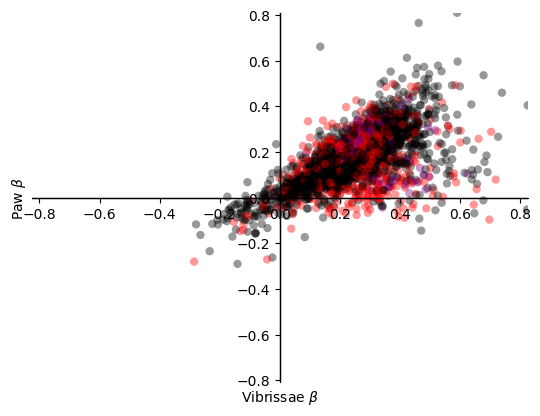

In [59]:
ROIs_to_plot = ["Vibrissae", "Paw"]

plot_scatter_of_GLM(all_GLM_coef_array[:, ROI_names.index(ROIs_to_plot[0])],
                    all_GLM_coef_array[:, ROI_names.index(ROIs_to_plot[1])], 
                    all_unit_colors, ROIs_to_plot)

## Pairs

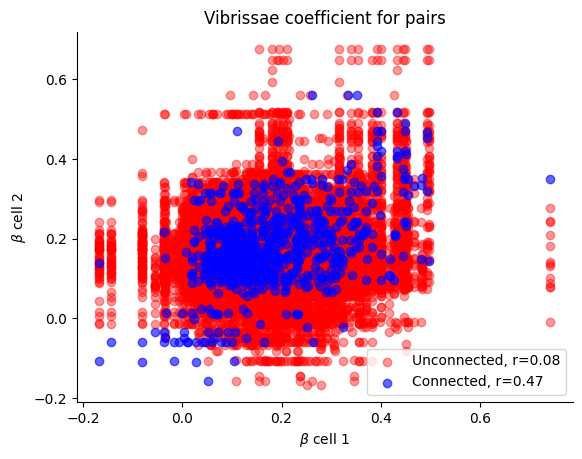

In [36]:
connected_pair_array = np.array(connected_pair).squeeze()
corr_con = np.round(np.corrcoef(connected_pair_array.T)[1,0], 2)
unconnected_pair_array = np.array(unconnected_pair).squeeze()
uncorr_con = np.round(np.corrcoef(unconnected_pair_array.T)[1,0], 2)


plt.scatter(unconnected_pair_array[:, 0], unconnected_pair_array[:, 1], color="red", alpha=0.4)
plt.scatter(connected_pair_array[:, 0], connected_pair_array[:, 1], color="blue", alpha=0.6)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.ylabel(f"$\\beta$ cell 2")
plt.legend(["Unconnected, r=" + str(uncorr_con), "Connected, r=" + str(corr_con)])
plt.title(ROI_names[ROI_con] + " coefficient for pairs")
plt.show()

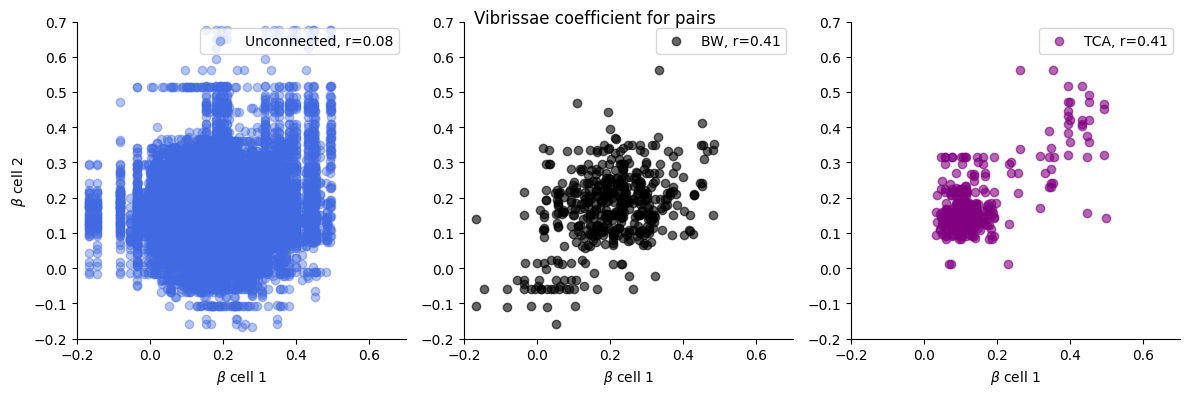

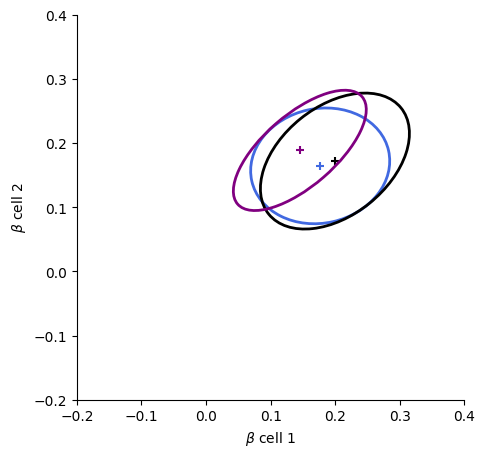

In [37]:
connected_pair_array = np.array(connected_pair).squeeze()
BW_pairs = connected_pair_array[np.array(connected_color) == "black", :]
TCA_pairs = connected_pair_array[np.array(connected_color) == "purple", :]

corr_BW = np.round(np.corrcoef(BW_pairs.T)[1,0], 2)
corr_TCA = np.round(np.corrcoef(TCA_pairs.T)[1,0], 2)
unconnected_pair_array = np.array(unconnected_pair).squeeze()
uncorr_con = np.round(np.corrcoef(unconnected_pair_array.T)[1,0], 2)

colors_pairs = ["royalblue", "black", "purple"]
lims = (-0.2,0.7)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(unconnected_pair_array[:, 0], unconnected_pair_array[:, 1], color=colors_pairs[0], alpha=0.4)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.ylabel(f"$\\beta$ cell 2")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(["Unconnected, r=" + str(uncorr_con)], loc="upper right")

plt.subplot(1,3,2)
plt.scatter(BW_pairs[:, 0], BW_pairs[:, 1], color=colors_pairs[1], alpha=0.6)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(["BW, r=" + str(corr_BW)])

plt.subplot(1,3,3)
plt.scatter(TCA_pairs[:, 0], TCA_pairs[:, 1], color=colors_pairs[2], alpha=0.6)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(["TCA, r=" + str(corr_BW)])

plt.tight_layout()
plt.suptitle(ROI_names[ROI_con] + " coefficient for pairs")
plt.show()

# second plot
plt.figure(figsize=(5,5))
for i,array in enumerate([unconnected_pair_array, BW_pairs, TCA_pairs]):
    mean = np.mean(array, axis=0)
    plt.scatter(mean[0], mean[1], color=colors_pairs[i], marker="+")

    pca = PCA(n_components=2)
    pca.fit(array)
    axis_length = np.sqrt(pca.explained_variance_)
    angle = np.arctan2(pca.components_[0, 1], pca.components_[0, 0]) * 180 / np.pi

    # Create the ellipse
    ellipse = Ellipse(xy=mean, width=2*axis_length[0], height=2*axis_length[1], angle=angle, 
                      edgecolor=colors_pairs[i], facecolor='none', linewidth=2)
    plt.gca().add_patch(ellipse)
plt.xlim(-0.2,0.4)
plt.ylim(-0.2,0.4)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.ylabel(f"$\\beta$ cell 2")
plt.show()

## Clustering

In [44]:
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(all_GLM_coef_array)
clusters = np.unique(hdb.labels_).tolist()

n_type = 3
N = all_GLM_coef_array.shape[0]
n_type_per_cluster = np.zeros((n_type, len(clusters) - 1))
mean_coef_cluster = np.zeros((n_ROIs, len(clusters) - 1))
for i, cluster_i in enumerate(clusters[1:]):

    mean_coef_cluster[:, i] = np.mean(all_GLM_coef_array[hdb.labels_ == i, :], axis= 0)

    for j, color in enumerate(np.unique(all_unit_colors)):
        mask = (hdb.labels_ == cluster_i) & (all_unit_colors == color)
        n_type_per_cluster[j, i] = np.sum(mask)

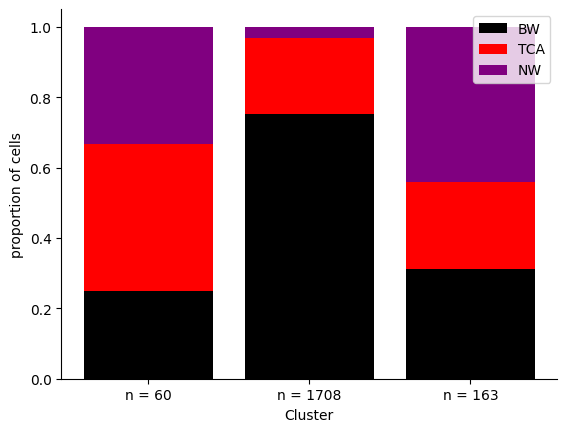

In [57]:
colors = ["black","purple","red"]
n_per_cluster = np.sum(n_type_per_cluster, axis = 0)
norm_type_per_cluster = n_type_per_cluster / n_per_cluster
cluster_names = []
for i, cluster_i in enumerate(clusters[1:]):
    cluster_names.append("n = " + str(int(n_per_cluster[i])))

bottom = np.zeros(len(clusters) - 1)
for i in [0,2,1]:
    plt.bar(cluster_names, norm_type_per_cluster[i,:], bottom=bottom, facecolor=colors[i])
    bottom += norm_type_per_cluster[i,:]

plt.legend(["BW", "TCA", "NW"])
plt.xlabel("Cluster")
plt.ylabel("proportion of cells")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

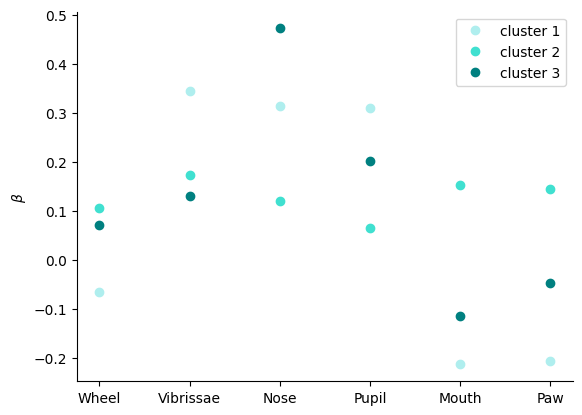

In [58]:
color_clusters = ["paleturquoise","turquoise","teal"]
for i in range(mean_coef_cluster.shape[1]):
    plt.plot(np.arange(n_ROIs), mean_coef_cluster[:, i], marker ="o", 
             linestyle="",color=color_clusters[i])
    
plt.legend(["cluster 1", "cluster 2", "cluster 3"])
plt.xticks(ticks=range(n_ROIs), labels=ROI_names)
plt.ylabel(f"$\\beta$")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()
